# Реальный газ

![](https://upload.wikimedia.org/wikipedia/commons/thumb/a/a5/Das_Lachta_Zentr-_%D0%9B%D0%B0%D1%85%D1%82%D0%B0_%D0%A6%D0%B5%D0%BD%D1%82%D1%80_2H1A6038WI.jpg/445px-Das_Lachta_Zentr-_%D0%9B%D0%B0%D1%85%D1%82%D0%B0_%D0%A6%D0%B5%D0%BD%D1%82%D1%80_2H1A6038WI.jpg)

На самом деле не этот =). Мы будем моделировать неидеальный [одноатомный газ](https://ru.wikipedia.org/wiki/%D0%9F%D0%BE%D1%82%D0%B5%D0%BD%D1%86%D0%B8%D0%B0%D0%BB_%D0%9B%D0%B5%D0%BD%D0%BD%D0%B0%D1%80%D0%B4%D0%B0-%D0%94%D0%B6%D0%BE%D0%BD%D1%81%D0%B0#%D0%9F%D1%80%D0%B8%D0%BC%D0%B5%D0%BD%D0%B5%D0%BD%D0%B8%D0%B5_%D0%B2_%D0%BA%D0%BE%D0%BC%D0%BF%D1%8C%D1%8E%D1%82%D0%B5%D1%80%D0%BD%D0%BE%D0%BC_%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B8), который (обычно) не горит.

Будем использовать (хотя он [не единственный](https://de.wikipedia.org/wiki/Morse-Potential) подходит) [потенциал Леннарда-Джонса](https://ru.wikipedia.org/wiki/%D0%9F%D0%BE%D1%82%D0%B5%D0%BD%D1%86%D0%B8%D0%B0%D0%BB_%D0%9B%D0%B5%D0%BD%D0%BD%D0%B0%D1%80%D0%B4%D0%B0-%D0%94%D0%B6%D0%BE%D0%BD%D1%81%D0%B0#%D0%9F%D1%80%D0%B8%D0%BC%D0%B5%D0%BD%D0%B5%D0%BD%D0%B8%D0%B5_%D0%B2_%D0%BA%D0%BE%D0%BC%D0%BF%D1%8C%D1%8E%D1%82%D0%B5%D1%80%D0%BD%D0%BE%D0%BC_%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B8):

$$
\begin{cases}
U(r)=4 \varepsilon \left[ \left( \frac{\sigma}{r} \right)^{12} - \left( \frac{\sigma}{r} \right)^6 \right] - U_{LJ}(r_c) & r \leqslant r_c, \\
0 & r > r_c,
\end{cases}
$$

Если взять градиент этого потенциала, он будет пропорционален:

$$
24 \varepsilon \left( \frac{\sigma^6}{r^7} - \frac{2\sigma^{12}}{r^{13}} \right)
$$

In [1]:
import numba
from numba import njit, prange
import matplotlib.pyplot as plt
import numpy
from numpy import array as mkvec
from numpy.linalg import norm

%config InlineBackend.figure_formats = ['svg',  'pdf']
%matplotlib inline

### Определим константы

In [2]:
PARTICLE_EPSILON: float = 10.0
PARTICLE_SIGMA  : float = 1.0
PARTICLE_MASS   : float = 1.0
    
PARTICLE_I_VEL  : float = 1e-3

PARTICLE_SAME   : float = 1e-5
PARTICLE_FAR    : float = 0.25

PARTICLE_NUMBER : int   = 10

MODEL_DELTA_T   : float = 1e-6
MODEL_TIME_TO   : float = 1e-2

MODEL_SKIP_DRAW : int = 2

In [3]:
@njit(
    numba.float64(numba.float64),
    fastmath=True)
def r_force_lennard_jones(r: float)->float:
    if PARTICLE_SAME <= r <= PARTICLE_FAR:
        return 24.0 * PARTICLE_EPSILON * (PARTICLE_SIGMA**6 / r**7 - 2 * PARTICLE_SIGMA**12 / r**13)
    else:
        return 0.0

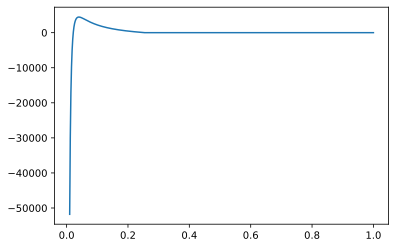

In [4]:
@njit(
    numba.float64(numba.float64),
    fastmath=True)
def r_force(r: float)->float:
    if PARTICLE_SAME <= r <= PARTICLE_FAR:
        return PARTICLE_EPSILON * (PARTICLE_SIGMA**2 * (50.0 / r - 1 / r**2) - 180.0)
    else:
        return 0.0

rs = numpy.linspace(1e-2, 1, 500)
plt.plot(rs, numpy.vectorize(r_force)(rs))

In [5]:
zerovec = mkvec([0.0, 0.0], dtype=float)
zeros = numpy.zeros((PARTICLE_NUMBER, 2), dtype=float)

@njit(
    # numba.float64[:](numba.float64[:], numba.float64[:]), ??
    fastmath=True
)
def force_induced(to_p, by_p):
    r = norm(to_p - by_p)
    f = r_force(r)
    if f != 0.0:
        return f * (to_p - by_p) / r
    else:
        return zerovec

Напихаем частиц в стакан

In [6]:
def init_particles():
    global curr_coordinates, prev_coordinates
    curr_coordinates =  numpy.random.uniform(low=0.0, high=1.0, size=(PARTICLE_NUMBER, 2))
    curr_coordinates *= mkvec([1, 0.5])  # сдвинем все в нижнюю половину стакана
    # curr_coordinates += mkvec([0, 0.1])
    prev_coordinates =  curr_coordinates +\
        numpy.random.uniform(low=-PARTICLE_I_VEL, high=PARTICLE_I_VEL, size=(PARTICLE_NUMBER, 2))

init_particles()
    
@njit(
    numba.float64[:](numba.int32),
    fastmath=True
)
def particle_velocity(idx: int):
    return (curr_coordinates[idx] - prev_coordinates[idx]) / MODEL_DELTA_T

Наконец-то, шаг моделирования!

In [7]:
@njit(
    numba.void(numba.float64[:,:],numba.float64[:,:]),
    fastmath=True, parallel=True
)
def model_step(cc, pc):
    nc = (2.0 * cc - pc)

    for i in prange(PARTICLE_NUMBER):
        force_i = zerovec.copy()
        # другие частицы
        for j in range(PARTICLE_NUMBER):
            if j != i:
                force_i += force_induced(cc[i], cc[j])
        # и стенки
        force_i += force_induced(cc[i], mkvec([cc[i,0], 0.0]))
        force_i += force_induced(cc[i], mkvec([cc[i,0], 1.0]))
        force_i += force_induced(cc[i], mkvec([0.0, cc[i,1]]))
        force_i += force_induced(cc[i], mkvec([1.0, cc[i,1]]))

        nc[i] += force_i / PARTICLE_MASS * MODEL_DELTA_T ** 2 # $a \delta_t^2$

    # и так numba не умеет
    # prev_coordinates = curr_coordinates
    # curr_coordinates = next_coordinates
    # и так тоже =)
    # numpy.copyto(prev_coordinates, curr_coordinates)
    # numpy.copyto(curr_coordinates, next_coordinates)
    pc[:] = cc[:]
    cc[:] = nc[:]

OMP: Info #273: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [8]:
def perform_modelling():
    global curr_coordinates, prev_coordinates
    for t in numpy.linspace(0.0, MODEL_TIME_TO, round(MODEL_TIME_TO / MODEL_DELTA_T)):
        # print(t)
        model_step(curr_coordinates, prev_coordinates)
        # curr_coordinates += 0.0001
        # print(max(curr_coordinates[:,1] - prev_coordinates[:,1]))

In [9]:
# %timeit perform_modelling()

<IPython.core.display.Javascript object>


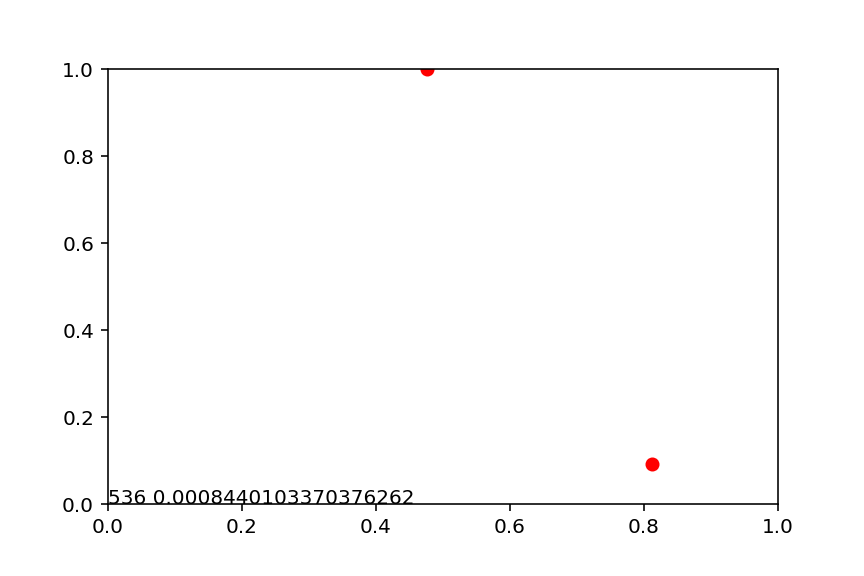

In [10]:
import matplotlib.animation as animation
%matplotlib notebook

fig, ax = plt.subplots()

plt.xlim([0, 1])
plt.ylim([0, 1])


init_particles()
particles, = plt.plot(curr_coordinates[:,0], curr_coordinates[:,1], 'ro')
label = ax.text(0, 0, "0")
# particles, = plt.plot([0], [0], 'ro')


def animate(frame_no):
    # print(frame_no)
    if 0 == frame_no:
        init_particles()
    for _ in range(MODEL_SKIP_DRAW):
        model_step(curr_coordinates, prev_coordinates)
    label.set_text(str(frame_no) + ' ' + str(max(curr_coordinates[:,1] - prev_coordinates[:,1])))
    particles.set_data(curr_coordinates[:,0], curr_coordinates[:,1])
    # particles.set_data([0, frame_no/1000], [0, frame_no/1000])
    return particles,

ma = animation.FuncAnimation(
    fig, animate,
    frames=round(MODEL_TIME_TO / MODEL_DELTA_T),
    interval=3, blit=True, repeat=True
)

plt.show()